In [467]:
#import relevent libraries 
import math
import random
import itertools
from collections import defaultdict,Counter
from statistics import mean
import numpy as np
import heapq

def generate_balanced_tuples(t: int, b=lambda t: t * 2, k=4, max_item=lambda t: t):

    #input value key:
    #t = number of items, integer
    #b = the number of tuples desired 
    #k = tuple size, integer
    #max_item = the number of items sorted by frequency looped over to generate possible 
    #pairs choosing max_item lower than t can speed up tuple generation, likely at the 
    #expense of pair frequency balance
    
    b = b(t) if callable(b) else b
    max_item = max_item(t) if callable(max_item) else max_item
    
    #if b is not provided, we assume b = 2t
    #Similarly, if max_item is not provided, we assume t
    #if k is not provided, we assume k=4
    
    
    #getting a max pair value: 
    
    #total number of pairs per tuple (for 4-tuples, pairs_per_tuple will always be 6):
    pairs_per_tuple = math.factorial(k) / (math.factorial(2) * math.factorial(k-2))

    #how many pairs will appear in our tuples:
    total_pairs = pairs_per_tuple * b

    #how many posible pairs are there: 
    unique_pairs = math.factorial(t)/(math.factorial(2)* math.factorial(t-2))

    #get a lambda value to dictate a maximum pair frequency
    lambda_value = total_pairs/unique_pairs

    #use counters to keep track of item and pair frequencies
    item_counts = Counter()
    pair_counts_total = Counter()
    tuples_list = []
    tuple_signatures = set()  # Using a set for fast duplicate checks of tuples 
    
    def get_list(item_counts, current_tuple):
        # iterating over the list
        eligible_items = [item for item in range(t) if item not in current_tuple]
        eligible_items.sort(key=lambda x: (item_counts[x], x))
        if len(eligible_items) < max_item: 
            return eligible_items
        else:
            return eligible_items[:max_item]

        #check if a tuple exists in the current list of tuples

    def generate_signature(sublist):
        # Generating a sorted tuple signature for the sublist
        return tuple(sorted(sublist))
    
    def get_min_item_with_heap(dict_1, dict_2):
        # Create a list of tuples: (value from dict_2, value from dict_1, key)
        heap = [(dict_2[key], dict_1.get(key, 0), key) for key in dict_2]

        # Transform the list into a heap
        heapq.heapify(heap)

        # The smallest item based on your criteria is now at the root of the heap
        return heap[0][2]


    while len(tuples_list) < b:
        current_tuple = []
        #for the first item in a tuple, automatically add the item with the least 
        #frequency across existing tuples:
        sorted_list = get_list(item_counts, current_tuple)
        current_tuple.append(sorted_list[0])
        #update the item count after appending:
        item_counts[sorted_list[0]] += 1
        #now a while loop for remaining items to be added to the tuple: 
        while len(current_tuple) < k:
            #assume that we won't find an item with summed pair frequencies with 
            #other items in the tuple < lambda:
            lambda_match = False
            #sort the list each time a new item has been added:
            sorted_list = get_list(item_counts, current_tuple)
            #keep track of the summed pair frequencies of considered items with 
            #existing items in the tuple:
            frequency_counts_total = {} 
            # only consider items if they would not replicate existing tuples (only 
            #relevent for the last item in a tuple):
            for item in sorted_list:
                phony_tuple = current_tuple + [item]
                phony_signature = generate_signature(phony_tuple)
                if phony_signature not in tuple_signatures:
                    #if the duplicate tuple criteria has been satisfied, store the 
                    #pair frequencies with items already in the tuple:
                    frequency_counts = {}
                    pair_list = list(itertools.combinations(current_tuple+[item], 2))
                    for pair in pair_list:
                        pair = tuple(sorted(pair))
                        frequency_counts[pair] = pair_counts_total[pair]
                    frequency_counts_total[item] = sum(frequency_counts.values())    
                    #if the summed pair counts are less than lambda, we can break 
                    #the loop because we've found a suitable item: 
                    if sum(frequency_counts.values()) < lambda_value:
                        current_tuple.append(item)
                    #after appending the item, update the item frequencies:
                        item_counts[item] += 1
                        lambda_match = True
                    if lambda_match:
                        break
            #if there's no available item with summed pair frequencies with items 
            #already in the tuple < lambda, get the item with primarily the mimimum 
            #pair frequency and secondarily the smallest item frequency in the case 
            #of ties:
            if not lambda_match:
                min_item = get_min_item_with_heap(item_counts, frequency_counts_total)
                current_tuple.append(min_item)
                item_counts[min_item] += 1
        
        # Update the pair counts here once the tuple is finalized 
        current_tuple_pairs = list(itertools.combinations(current_tuple, 2))
        for pair in current_tuple_pairs:
            pair = tuple(sorted(pair))
            pair_counts_total[pair] += 1

        #append tuple to tuple list 
        tuples_list.append(current_tuple)
        #for each finalised tuple add it as a set to a wider set for fast duplicate checks
        tuple_signature = generate_signature(current_tuple)
        tuple_signatures.add(tuple_signature)
    
    #now we are going to compute metrics to return with the tuples. We will give the min, 
    #max, mean and standard deviation of item and pair counts respectively. Will will aslo
    #return a frequency table as this is an efficient way of giving information about 
    #balance, and all the above metrics and more can be deduced from the frequency table 
        
    #item metrics:
    #because we've used a counter, we need to manually append 0 counts. 
    items_with_zero_count = int(t - len(item_counts))
    item_counts = list(item_counts.values()) + [0] * items_with_zero_count
    
    item_metrics = {}
    item_metrics["mean"] = mean(item_counts)
    item_metrics["max"] = max(item_counts)
    item_metrics["min"] = min(item_counts)
    item_metrics["standard deviation"] = np.std(list(item_counts))
    
    #frequency count: 
    frequency = {}
    # iterating over the list
    for item in item_counts:
       # checking the element in dictionary
        if item in frequency:
            frequency[item] += 1
        else:
            frequency[item] = 1
    
    #combine the two dictionaries into one dictionary: 
    item_info = {"metrics": item_metrics, "frequencies": frequency}
    
    #pair metrics:
    #because we've used a counter, we need to manually append 0 counts. 
    #we've already calculated the number of unique pairs and therefore can derive 0 counts 
    pairs_with_zero_count = int(unique_pairs - len(pair_counts_total))
    
    pair_counts = list(pair_counts_total.values()) + [0] * pairs_with_zero_count
    pair_metrics = {}
    pair_metrics["mean"] = mean(pair_counts)
    pair_metrics["max"]= max(pair_counts)
    pair_metrics["min"] = min(pair_counts)
    pair_metrics["standard deviation"] = np.std(list(pair_counts))
    
    frequency_pair = {}
    # iterating over the list
    for pair in pair_counts:
       # checking the element in dictionary
        if pair in frequency_pair:
            frequency_pair[pair] += 1
        else:
            frequency_pair[pair] = 1

    pair_info = {"metrics": pair_metrics, "frequencies": frequency_pair}
    
    #return the list of tuples and the item and pair metrics
    return tuples_list, item_info, pair_info

In [474]:
results2N = generate_balanced_tuples(t=50, b=100,k=4)
results3N = generate_balanced_tuples(t=50, b=150,k=4)

In [475]:
print(results2N[1])
print(results2N[2])
print(results3N[1])
print(results3N[2])

{'metrics': {'mean': 8, 'max': 9, 'min': 7, 'standard deviation': 0.282842712474619}, 'frequencies': {8: 46, 9: 2, 7: 2}}
{'metrics': {'mean': 0.4897959183673469, 'max': 1, 'min': 0, 'standard deviation': 0.499895865874118}, 'frequencies': {1: 600, 0: 625}}
{'metrics': {'mean': 12, 'max': 13, 'min': 11, 'standard deviation': 0.34641016151377546}, 'frequencies': {12: 44, 13: 3, 11: 3}}
{'metrics': {'mean': 0.7346938775510204, 'max': 2, 'min': 0, 'standard deviation': 0.4718833392702936}, 'frequencies': {1: 866, 2: 17, 0: 342}}


In [306]:
def filter_dictionary(original_dict):
    # Define the desired key intervals
    desired_keys = [200,400,600,800] 
    filtered_dict = {}

    for dk in desired_keys:
        # Find the nearest key in the specified range
        nearest_key = min(
        (key for key in original_dict.keys() if dk - 50 <= key <= dk + 50),
        key=lambda k: abs(k - dk),
        default=None
        )

        # Add the nearest key to the filtered dictionary if it exists
        if nearest_key is not None:
            filtered_dict[nearest_key] = original_dict[nearest_key]

    return filtered_dict

In [307]:
lambda_values = [0.25, 0.50, 0.75, 1.0]
lambda_dictionary = {}

for lambda_value in lambda_values:
    k_dictionary = {}
    for k in range(4, 8):
        pairs_per_tuple = math.factorial(k) / (math.factorial(2) * math.factorial(k - 2))
        B_dictionary = {}
        for n in range(150,850):
            b = (lambda_value * (math.factorial(n)/(math.factorial(2) * math.factorial(n-2))))/ pairs_per_tuple
            num = k*(b/n)
            if num.is_integer() and b.is_integer():  # Checking if B is an integer
                B_dictionary[n] = int(num)   # Casting B to int for storage
        if B_dictionary:
            B_dictionary = filter_dictionary(B_dictionary)
            k_dictionary[k] = B_dictionary
    if k_dictionary:
        lambda_dictionary[lambda_value] = k_dictionary

lambda_dictionary

{0.25: {4: {193: 16, 385: 32, 577: 48, 817: 68},
  5: {225: 14, 401: 25, 625: 39, 801: 50},
  6: {201: 10, 361: 18, 601: 30, 801: 40},
  7: {217: 9, 385: 16, 553: 23, 841: 35}},
 0.5: {4: {193: 32, 409: 68, 601: 100, 793: 132},
  5: {201: 25, 401: 50, 601: 75, 801: 100},
  6: {201: 20, 381: 38, 601: 60, 801: 80},
  7: {217: 18, 385: 32, 589: 49, 805: 67}},
 0.75: {4: {193: 48, 401: 100, 593: 148, 801: 200},
  5: {225: 42, 401: 75, 625: 117, 801: 150},
  6: {201: 30, 401: 60, 601: 90, 801: 120},
  7: {217: 27, 393: 49, 609: 76, 785: 98}},
 1.0: {4: {196: 65, 400: 133, 601: 200, 796: 265},
  5: {201: 50, 401: 100, 601: 150, 801: 200},
  6: {201: 40, 396: 79, 601: 120, 801: 160},
  7: {211: 35, 385: 64, 595: 99, 799: 133}}}

In [309]:
lambda_values = [0.25, 0.50, 0.75, 1.0]
lambda_dictionary = {}

for lambda_value in lambda_values:
    k_dictionary = {}
    for k in range(4, 8):
        pairs_per_tuple = math.factorial(k) / (math.factorial(2) * math.factorial(k - 2))
        B_dictionary = {}
        for n in range(150,850):
            b = (lambda_value * (math.factorial(n)/(math.factorial(2) * math.factorial(n-2))))/ pairs_per_tuple
            num = k*(b/n)
            if num.is_integer() and b.is_integer():  # Checking if B is an integer
                B_dictionary[n] = int(b)   # Casting B to int for storage
        if B_dictionary:
            B_dictionary = filter_dictionary(B_dictionary)
            k_dictionary[k] = B_dictionary
    if k_dictionary:
        lambda_dictionary[lambda_value] = k_dictionary

lambda_dictionary


{0.25: {4: {193: 772, 385: 3080, 577: 6924, 817: 13889},
  5: {225: 630, 401: 2005, 625: 4875, 801: 8010},
  6: {201: 335, 361: 1083, 601: 3005, 801: 5340},
  7: {217: 279, 385: 880, 553: 1817, 841: 4205}},
 0.5: {4: {193: 1544, 409: 6953, 601: 15025, 793: 26169},
  5: {201: 1005, 401: 4010, 601: 9015, 801: 16020},
  6: {201: 670, 381: 2413, 601: 6010, 801: 10680},
  7: {217: 558, 385: 1760, 589: 4123, 805: 7705}},
 0.75: {4: {193: 2316, 401: 10025, 593: 21941, 801: 40050},
  5: {225: 1890, 401: 6015, 625: 14625, 801: 24030},
  6: {201: 1005, 401: 4010, 601: 9015, 801: 16020},
  7: {217: 837, 393: 2751, 609: 6612, 785: 10990}},
 1.0: {4: {196: 3185, 400: 13300, 601: 30050, 796: 52735},
  5: {201: 2010, 401: 8020, 601: 18030, 801: 32040},
  6: {201: 1340, 396: 5214, 601: 12020, 801: 21360},
  7: {211: 1055, 385: 3520, 595: 8415, 799: 15181}}}

In [310]:
lambda_dictionary_025 = lambda_dictionary[0.25] 
lambda_dictionary_050 = lambda_dictionary[0.5] 
lambda_dictionary_075 = lambda_dictionary[0.75] 
lambda_dictionary_01 = lambda_dictionary[1.0] 

In [311]:
import time

# Function to time a given function with a value of N
def time_function(func, dictionary):
    list_times = []
    for k in dictionary:
        timed_iter = []
        for n in dictionary[k]:
            b = dictionary[k][n]
            start_time = time.time()
            result = func(n = n,b = b,k = k)
            time_took = time.time() - start_time
            timed_iter.append([time_took, result[1], result[2]])
        list_times.append(timed_iter)
    return(list_times)

In [312]:
# Time the functions for each value of N
timed_function_025 = time_function(generate_balanced_tuples, lambda_dictionary_025)


In [313]:
timed_function_050 = time_function(generate_balanced_tuples, lambda_dictionary_050)

In [314]:
timed_function_075 = time_function(generate_balanced_tuples, lambda_dictionary_075)

In [315]:
timed_function_01 = time_function(generate_balanced_tuples, lambda_dictionary_01)

In [316]:
timed_function_all = [timed_function_025,timed_function_050, timed_function_075, timed_function_01]

In [465]:
#report the performance of the algorithm 
#for the items, standard deviation and range makes sense, because the delta standard deviation is the same - BIBD would be zero
#for pairs, range makes sense, and a delta standard deviation? calculated by square

metric_report = {}
lambda_values = [0.25,0.5,0.75,1]
k_values = [4,5,6,7]

for i in range(len(timed_function_all)):
    lamb_dict = {}
    lambda_value = lambda_values[i]
    for k_value in range(len(timed_function_all[i])):
        k = k_values[k_value]
        k_dictionary = {}
        for BIBDS in range(len(timed_function_all[i][k_value])):
            item_metric = timed_function_all[i][k_value][BIBDS][1]
            item_range_metric = item_metric['metrics']['max'] - item_metric['metrics']['min']
            item_standard_deviation = item_metric['metrics']['standard deviation']
            item_metrics = {"range":item_range_metric, "delta standard deviation":item_standard_deviation}
            pair_metric = timed_function_all[i][k_value][BIBDS][2]
            pair_range_metric = pair_metric['metrics']['max'] - pair_metric['metrics']['min']
            pair_standard_deviation = pair_metric['metrics']['standard deviation']
            t = list(lambda_dictionary[lambda_value][k].items())[BIBDS][0]
            ideal_pair_standard_deviation = math.sqrt(lambda_value * (1 - lambda_value))
            delta_pair_standard_deviation = pair_standard_deviation - ideal_pair_standard_deviation 
            pair_metrics = {"range":pair_range_metric, "delta standard deviation":delta_pair_standard_deviation}
            BIBDS_dictionary = {'item metrics':item_metrics, 'pair metrics': pair_metrics}
            k_dictionary[t] = BIBDS_dictionary
        lamb_dict[k] = k_dictionary
    metric_report[lambda_value] = lamb_dict

In [466]:
metric_report

{0.25: {4: {193: {'item metrics': {'range': 2,
     'delta standard deviation': 0.33762351414808106},
    'pair metrics': {'range': 1, 'delta standard deviation': 0.0}},
   385: {'item metrics': {'range': 2,
     'delta standard deviation': 0.30578831486257535},
    'pair metrics': {'range': 1, 'delta standard deviation': 0.0}},
   577: {'item metrics': {'range': 2,
     'delta standard deviation': 0.28842487435306374},
    'pair metrics': {'range': 1, 'delta standard deviation': 0.0}},
   817: {'item metrics': {'range': 2,
     'delta standard deviation': 0.3129204637703754},
    'pair metrics': {'range': 1, 'delta standard deviation': 0.0}}},
  5: {225: {'item metrics': {'range': 2,
     'delta standard deviation': 0.32659863237109044},
    'pair metrics': {'range': 1, 'delta standard deviation': 0.0}},
   401: {'item metrics': {'range': 2,
     'delta standard deviation': 0.3312486766547697},
    'pair metrics': {'range': 1, 'delta standard deviation': 0.0}},
   625: {'item metrics'

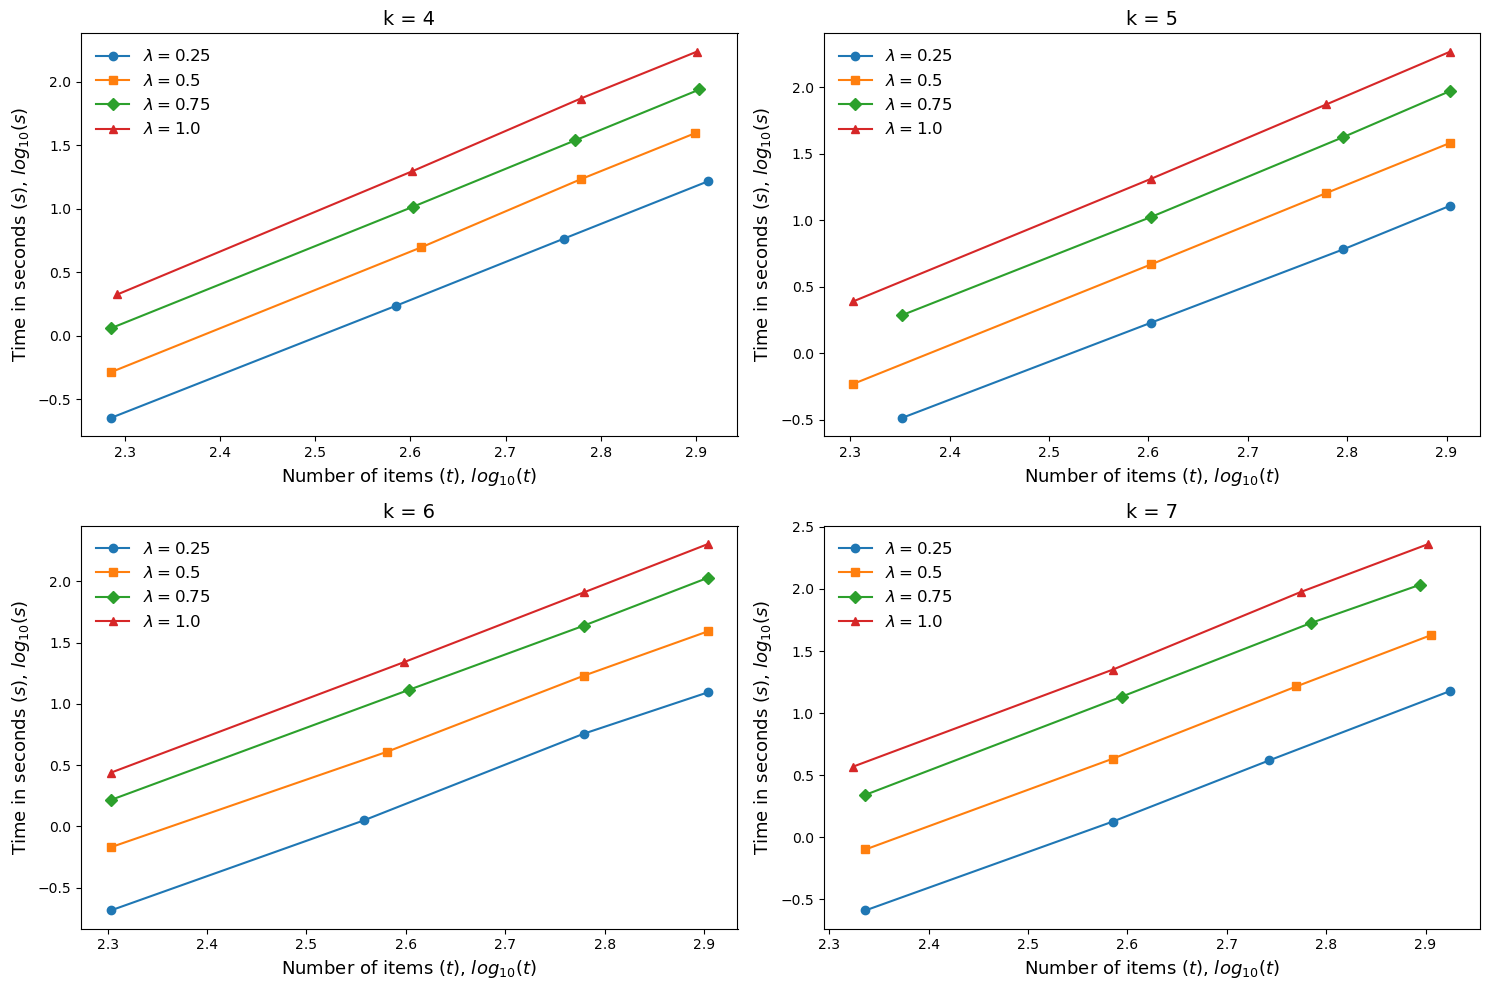

In [386]:
import matplotlib.pyplot as plt

# Your existing data here...

# Find unique k values
unique_k_values = set(k for k_values in lambda_dictionary.values() for k in k_values)

# Plot configuration
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()
markers = ['o', 's', 'D', '^', 'p']

# Loop through each k value
for k_idx, k in enumerate(sorted(unique_k_values)):
    ax = axs[k_idx]
    # Loop through each lambda value and its corresponding data
    for lambda_idx, (lambda_val, k_values) in enumerate(lambda_dictionary.items()):
        if k in k_values:
            x_values = list(k_values[k].keys())
            y_values = []
            for i in range(len(timed_function_all[lambda_idx][k_idx])):
                y_values.append(timed_function_all[lambda_idx][k_idx][i][0])
            y_values_ = []
            for y in y_values:
                y_values_.append(math.log(y,10))
            x_values_ = []
            for x in x_values:
                x_values_.append(math.log(x,10))
            ax.plot(x_values_, y_values_, marker=markers[lambda_idx], label=r'$\lambda = {}$'.format(lambda_val))


    # Adding labels, title and legend
    ax.set_xlabel(r"Number of items ($\it{t}$), $log_{10}(t)$",fontsize=13)
    ax.set_ylabel(r"Time in seconds ($\it{s}$), $log_{10}(s)$",fontsize=13)

    # Modify legend
    ax.legend(frameon=False, loc='upper left',fontsize=12)  # 'upper left' can be changed as per your preference
    ax.set_title(f'k = {k}',fontsize=14)

# Adjust layout
plt.tight_layout()

plt.savefig("/Users/benbirch/Desktop/my_plot1.svg", format='svg')
# Show the plot

plt.show()

In [506]:
#all times for iterations rounded 
for i in timed_function_all:
    for a in i:
        for b in a:
            print(np.format_float_positional(b[0], precision=3, unique=False, fractional=False, trim='k'))
            

0.224
1.72
5.80
16.4
0.327
1.70
6.03
12.8
0.206
1.12
5.69
12.4
0.258
1.34
4.17
15.1
0.514
4.97
17.0
39.4
0.59
4.67
16.0
38.0
0.675
4.05
16.9
39.0
0.799
4.30
16.4
42.5
1.14
10.4
34.5
86.9
1.93
10.6
42.0
93.3
1.64
13.0
43.4
107.
2.20
13.6
53.2
108.
2.11
19.7
73.7
173.
2.46
20.5
73.9
184.
2.74
21.8
81.0
201.
3.72
22.4
94.6
229.


In [462]:
#all times for iterations 

i_list = []
for i in timed_function_all:
    a_list = []
    for a in i:
        b_list = []
        for b in a:
            c_list = []
            for c in b:
                c_list.append(b[0])
                break
            b_list.append(c_list)
        a_list.append(b_list)
    i_list.append(a_list)       
i_list   

[[[[0.2243938446044922],
   [1.722679853439331],
   [5.799870014190674],
   [16.387648105621338]],
  [[0.3271169662475586],
   [1.7025070190429688],
   [6.028296947479248],
   [12.838016033172607]],
  [[0.20569705963134766],
   [1.1154038906097412],
   [5.693513870239258],
   [12.373969078063965]],
  [[0.25813722610473633],
   [1.3411500453948975],
   [4.166190147399902],
   [15.074969053268433]]],
 [[[0.5141870975494385],
   [4.965932130813599],
   [17.041101932525635],
   [39.38186192512512]],
  [[0.589562177658081],
   [4.667180061340332],
   [15.97133183479309],
   [38.03936195373535]],
  [[0.6746361255645752],
   [4.052967309951782],
   [16.930305004119873],
   [38.95170307159424]],
  [[0.7992339134216309],
   [4.3039209842681885],
   [16.421785831451416],
   [42.54791617393494]]],
 [[[1.1412768363952637],
   [10.373348236083984],
   [34.5193350315094],
   [86.87882399559021]],
  [[1.9341251850128174],
   [10.602007865905762],
   [42.00213289260864],
   [93.34342622756958]],
  [[1

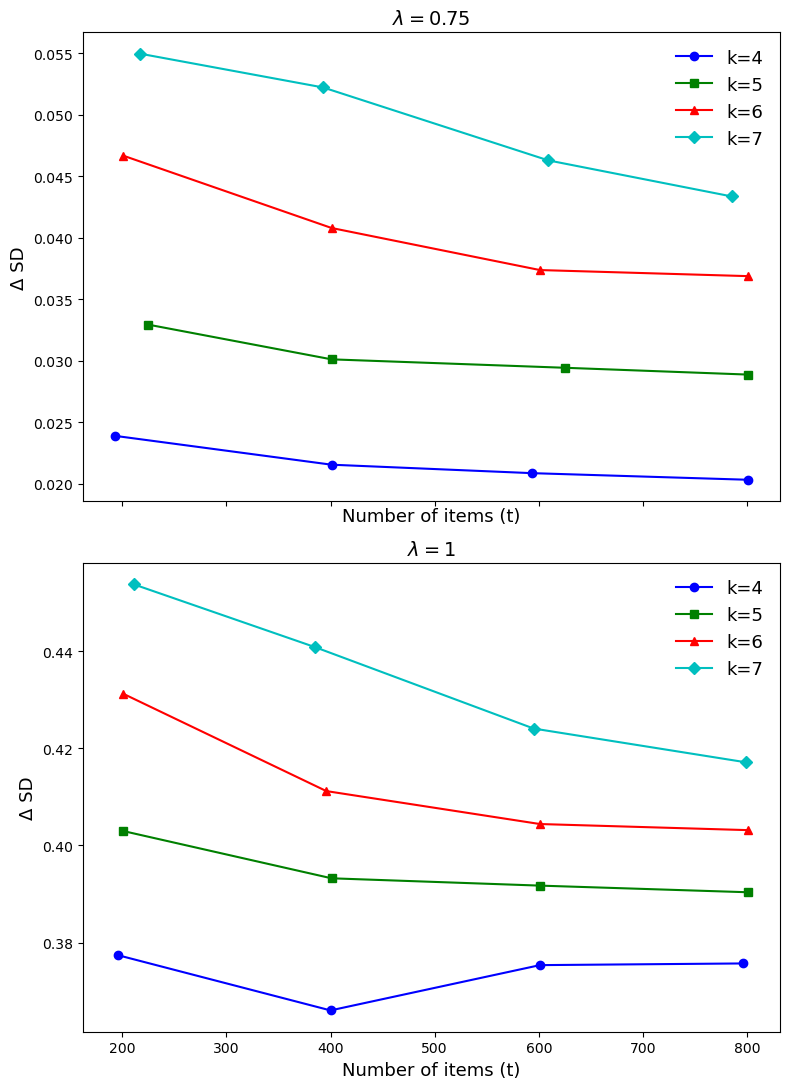

In [485]:
metric_report2 = {}
for i in metric_report:
    if i > 0.5:
        metric_report2[i] = metric_report[(i)]

# Re-plotting the data with correct settings

# Setup for plotting
fig, axs = plt.subplots(2, 1, figsize=(8, 11), sharex=True)
marker_styles = {4: 'o', 5: 's', 6: '^', 7: 'D'}  # Different marker for each k value
colors = ['b', 'g', 'r', 'c']  # Different color for each k value

# Plotting the data
for i, (lambda_value, k_data) in enumerate(metric_report2.items()):
    ax = axs[i]
    for j, (k, item_data) in enumerate(k_data.items()):
        x = []
        y = []
        for item_key, metrics in item_data.items():
            x.append(item_key)
            y.append(metrics['pair metrics']['delta standard deviation'])

        ax.plot(x, y, marker=marker_styles[k], color=colors[j], label=f'k={k}')

    ax.set_title(r'$\lambda = {}$'.format(lambda_value),fontsize=14)
    ax.legend(frameon=False, loc='upper right',fontsize=13)  
    ax.set_xlabel('Number of items (t)',fontsize=13)
    ax.set_ylabel('Δ SD',fontsize=13)

# Adjust layout for better visibility
plt.tight_layout()

plt.savefig("/Users/benbirch/Desktop/my_plot4.svg", format='svg')
# Display the graphs
plt.show()


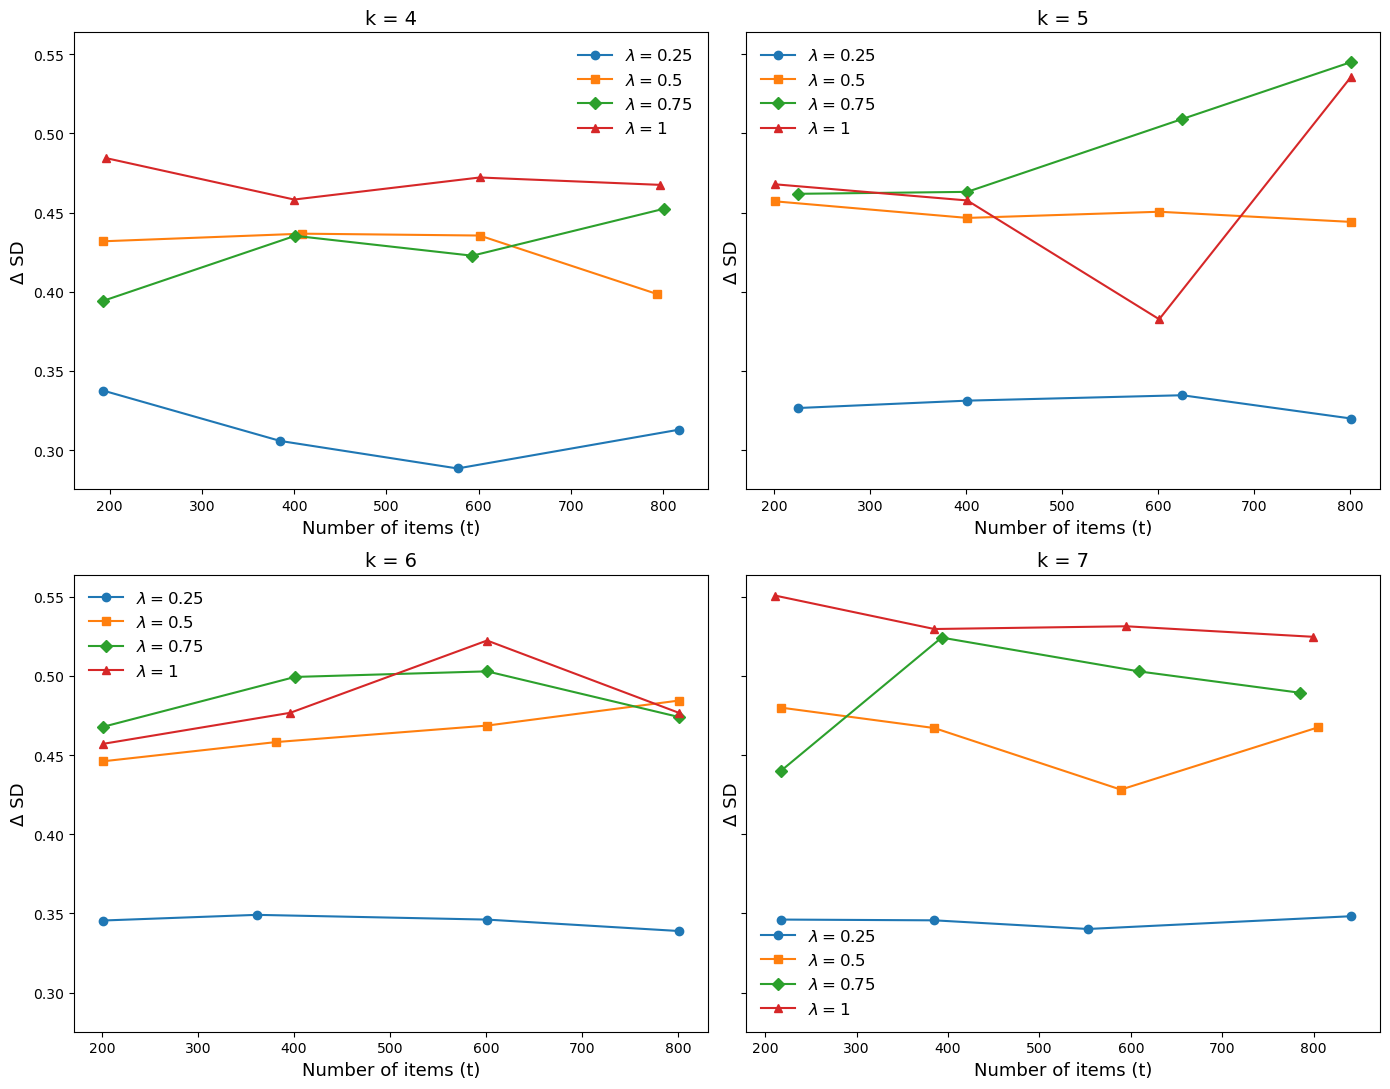

In [454]:
# Correcting the code to define the colors for different lambda values

# Define colors for different lambda values
markers = {0.25: 'o', 0.5: 's', 0.75: 'D', 1: '^'}

# Create a figure with 4 subplots (one for each k value)
fig, axes = plt.subplots(2, 2, figsize=(14, 11), sharey=True)
axes = axes.flatten()

# Iterate over each k value
for i, k in enumerate(range(4, 8)):
    ax = axes[i]

    # Iterate over each lambda value and its corresponding data
    for lambda_val, k_data in metric_report.items():
        if k in k_data:
            items = k_data[k]
            x = []  # item keys
            y = []  # delta standard deviations

            # Extract data for each item
            for item_key, metrics in items.items():
                x.append(item_key)
                y.append(metrics['item metrics']['delta standard deviation'])

            # Plot the data for this lambda value
            ax.plot(x, y, linestyle='-', marker=markers[lambda_val], label=r'$\lambda = {}$'.format(lambda_val))
    ax.legend(frameon=False,fontsize=12) 
    ax.set_title(f'k = {k}', fontsize=14)
    ax.set_xlabel('Number of items (t)',fontsize=13)
    ax.set_ylabel('Δ SD',fontsize=13)


# Adjust layout
plt.tight_layout()

plt.savefig("/Users/benbirch/Desktop/my_plot5.svg", format='svg')

# Show the plot
plt.show()
